In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, KFold
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
from sklearn.model_selection import RandomizedSearchCV

In [5]:
# ================== 0) SEED ==================
SEED = 42
np.random.seed(SEED)

# ================== 1) LOAD & PREP ==================
data_path = 'C:/Users/Multiplexon/Desktop/data/d6/total 06.csv'
df = pd.read_csv(data_path)

features = ['Original_len','Txn Fee','logIndex','actualGasCost',
            'Blockno','DateTime_ts','nonce']
target = 'Gas Used'

X = df[features].astype(float)
y = df[target].astype(float)

# ================== 2) HOLD-OUT (80/20 split) ==================
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=SEED
)

# ================== 3) MinMaxScaler cho X & y (fit trên TRAIN) ==================
xs = MinMaxScaler()
ys = MinMaxScaler()

X_train_prepared = xs.fit_transform(X_train)
X_test_prepared  = xs.transform(X_test)

y_train_prepared = ys.fit_transform(y_train.values.reshape(-1, 1)).ravel()
y_test_prepared  = ys.transform(y_test.values.reshape(-1, 1)).ravel()

# ================== 4) RandomizedSearchCV (CatBoost) ==================
param_distributions = {
    "n_estimators": [50, 100, 150],       # giảm số cây
    "max_depth": [3, 5, 7],               # giới hạn độ sâu
    "min_samples_split": [2, 5, 10],}

model = RandomForestRegressor()

ran_search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_distributions,
    n_iter=10,            # số tổ hợp thử (giảm để tiết kiệm RAM/CPU)
    cv=3,                 # k-fold cross validation
    n_jobs=1,             # chạy tuần tự để tránh copy dữ liệu
    random_state=42
)

ran_search.fit(X_train_prepared, y_train_prepared)

best_model   = ran_search.best_estimator_
best_params  = ran_search.best_params_
best_cv_rmse = np.sqrt(-ran_search.best_score_)   # RMSE trên THANG ĐÃ SCALE (y đã scale)

print("Best params:", best_params)
print(f"Best CV RMSE (scaled y): {best_cv_rmse:.6f}")

Best params: {'n_estimators': 50, 'min_samples_split': 5, 'max_depth': 7}
Best CV RMSE (scaled y): nan


C:\Users\Multiplexon\AppData\Local\Temp\ipykernel_21792\2531157902.py:52: RuntimeWarning: invalid value encountered in sqrt
  best_cv_rmse = np.sqrt(-ran_search.best_score_)   # RMSE trên THANG ĐÃ SCALE (y đã scale)


In [8]:
# ==== 0. Seed & Load Data ====
SEED = 42
np.random.seed(SEED)

data_path = 'C:/Users/Multiplexon/Desktop/data/d6/total 06.csv'
df = pd.read_csv(data_path)

# ==== 1. Feature Engineering & Cleaning ====
features = ['Original_len', 'Txn Fee', 'logIndex', 'actualGasCost',
            'Blockno', 'DateTime_ts', 'nonce']
target = 'Gas Used'

X = df[features].apply(pd.to_numeric, errors='coerce').replace([np.inf, -np.inf], np.nan).fillna(0.0)
y = pd.to_numeric(df[target], errors='coerce').replace([np.inf, -np.inf], np.nan).fillna(0.0)

# ==== 2. Train/Test Split ====
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)

# ==== 3. K-Fold CV ====
kf = KFold(n_splits=10, shuffle=True, random_state=SEED)

mse_list, rmse_list, mae_list, r2_list = [], [], [], []
all_true, all_pred = [], []

print("=== K-Fold RandomForest – Metrics trên dữ liệu đã SCALE ===")
for fold, (tr_idx, test_idx) in enumerate(kf.split(X_train), start=1):
    X_tr, X_te = X_train.iloc[tr_idx], X_train.iloc[test_idx]
    y_tr, y_te = y_train.iloc[tr_idx], y_train.iloc[test_idx]

    # Scale theo từng fold
    sx, sy = MinMaxScaler(), MinMaxScaler()
    X_tr_s, X_te_s = sx.fit_transform(X_tr), sx.transform(X_te)
    y_tr_s = sy.fit_transform(y_tr.values.reshape(-1, 1)).ravel()
    y_te_s = sy.transform(y_te.values.reshape(-1, 1)).ravel()

    # Model
    model = RandomForestRegressor(n_estimators= 50, min_samples_split= 5, max_depth= 7)
    model.fit(X_tr_s, y_tr_s)

    # Predict
    y_pred_s = model.predict(X_te_s)
    # Metrics
    mse  = mean_squared_error(y_te_s, y_pred_s)
    rmse = np.sqrt(mse)
    mae  = mean_absolute_error(y_te_s, y_pred_s)
    r2   = r2_score(y_te_s, y_pred_s)

    mse_list.append(mse); rmse_list.append(rmse)
    mae_list.append(mae); r2_list.append(r2)

    print(f"[Fold {fold:2d}] RMSE: {rmse:.6f} | MSE: {mse:.6f} | MAE: {mae:.6f} | R²: {r2:.6f}")

# ==== 4. Trung bình ====
print("\n=== Trung bình qua 10 folds (trên dữ liệu scaled) ===")
print(f"Mean RMSE: {np.mean(rmse_list):.6f}")
print(f"Mean MSE : {np.mean(mse_list):.6f}")
print(f"Mean MAE : {np.mean(mae_list):.6f}")
print(f"Mean R²  : {np.mean(r2_list):.6f}")


=== K-Fold RandomForest – Metrics trên dữ liệu đã SCALE ===
[Fold  1] RMSE: 0.007490 | MSE: 0.000056 | MAE: 0.004713 | R²: 0.640198
[Fold  2] RMSE: 0.007384 | MSE: 0.000055 | MAE: 0.004784 | R²: 0.593876
[Fold  3] RMSE: 0.008309 | MSE: 0.000069 | MAE: 0.004795 | R²: 0.578311
[Fold  4] RMSE: 0.007292 | MSE: 0.000053 | MAE: 0.004723 | R²: 0.635813
[Fold  5] RMSE: 0.007768 | MSE: 0.000060 | MAE: 0.004790 | R²: 0.611712
[Fold  6] RMSE: 0.007751 | MSE: 0.000060 | MAE: 0.004793 | R²: 0.586716
[Fold  7] RMSE: 0.007541 | MSE: 0.000057 | MAE: 0.004762 | R²: 0.632989
[Fold  8] RMSE: 0.007644 | MSE: 0.000058 | MAE: 0.004798 | R²: 0.613726
[Fold  9] RMSE: 0.013848 | MSE: 0.000192 | MAE: 0.007249 | R²: 0.563734
[Fold 10] RMSE: 0.008417 | MSE: 0.000071 | MAE: 0.004863 | R²: 0.551840

=== Trung bình qua 10 folds (trên dữ liệu scaled) ===
Mean RMSE: 0.008345
Mean MSE : 0.000073
Mean MAE : 0.005027
Mean R²  : 0.600891


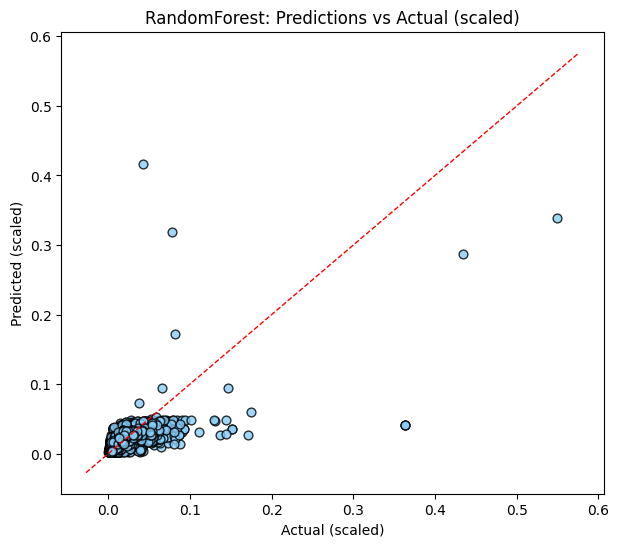

In [10]:
#actual and predicted scatter plot
# ================== 4) SCATTER PLOT with Gradient Color ==================
from sklearn.ensemble import RandomForestRegressor
import numpy as np
import matplotlib.pyplot as plt

# ================== 0) SEED ==================
SEED = 42
np.random.seed(SEED)
# ================== 4) TRAIN CATBOOST (SCALED) ==================
cb = RandomForestRegressor(n_estimators= 50, min_samples_split= 5, max_depth= 7)

cb.fit(X_tr_s, y_tr_s)

# ================== 5) PREDICT & SCATTER (SCALED) ==================
y_val_pred_s = cb.predict(X_te_s)

fig, ax = plt.subplots(figsize=(7, 6))
ax.scatter(y_te_s, y_val_pred_s, s=40, alpha=0.8,
           color="lightskyblue", edgecolors="k")

# Đường y = x theo giới hạn hiện tại của trục (không dùng 'lims')
x0, x1 = ax.get_xlim()
y0, y1 = ax.get_ylim()
ax.plot([min(x0, y0), max(x1, y1)], [min(x0, y0), max(x1, y1)],
        "--", lw=1, color="red")

ax.set_title("RandomForest: Predictions vs Actual (scaled)")
ax.set_xlabel("Actual (scaled)")
ax.set_ylabel("Predicted (scaled)")
plt.show()

In [11]:
# ================== 0) SEED ==================
SEED = 42
np.random.seed(SEED)

data_path = 'C:/Users/Multiplexon/Desktop/data/d6/total 06.csv'
df = pd.read_csv(data_path)

features = [
  'Original_len',
'Txn Fee','logIndex','actualGasCost',
    'Blockno','DateTime_ts', 'nonce'
]
target = 'Gas Used'


X = df[features].astype(float)
y = df[target].astype(float)

# Hold-out chỉ để cố định tập làm việc (không dùng test ở dưới)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)

# ================== 2) 20 EPOCHS × 10-FOLD ==================
epochs = 20
rd = np.zeros((epochs, 4), dtype=np.float64)   # [RMSE, MSE, MAE, R2]

for ep in range(epochs):
    # shuffle train cho epoch này
    idx = np.random.permutation(len(X_train))
    X_ep = X_train.iloc[idx].reset_index(drop=True)
    y_ep = y_train.iloc[idx].reset_index(drop=True)

    kf=KFold(n_splits=10, shuffle=True, random_state=SEED)

    rmse_scores, mse_scores, mae_scores, r2_scores = [], [], [], []

    for train_idx, test_idx in kf.split(X_ep):
        X_tr_raw, X_te_raw = X_ep.iloc[train_idx], X_ep.iloc[test_idx]
        y_tr_raw, y_te_raw = y_ep.iloc[train_idx], y_ep.iloc[test_idx]

        # scale TRONG fold (fit trên train → transform train/val)
        xs, ys = MinMaxScaler(), MinMaxScaler()
        X_tr_s = xs.fit_transform(X_tr_raw)
        X_te_s = xs.transform(X_te_raw)
        y_tr_s = ys.fit_transform(y_tr_raw.values.reshape(-1,1)).ravel()
        y_te_s = ys.transform(y_te_raw.values.reshape(-1,1)).ravel()

        # XGBoost (params mặc định, thêm random_state cho tái lập)
        model = RandomForestRegressor(n_estimators= 50, min_samples_split= 5, max_depth= 7)
        model.fit(X_tr_s, y_tr_s)

        # metrics trên dữ liệu ĐÃ SCALE
        y_pred_s = model.predict(X_te_s)
        mse  = mean_squared_error(y_te_s, y_pred_s)
        rmse = float(np.sqrt(mse))
        mae  = mean_absolute_error(y_te_s, y_pred_s)
        r2   = r2_score(y_te_s, y_pred_s)

        rmse_scores.append(rmse); mse_scores.append(mse)
        mae_scores.append(mae);   r2_scores.append(r2)

    rd[ep, :] = [np.mean(rmse_scores), np.mean(mse_scores),
                 np.mean(mae_scores),  np.mean(r2_scores)]

# ================== 3) OUTPUT ==================
np.set_printoptions(precision=8, suppress=False)
print("array(" + np.array2string(rd, separator=', ', prefix='array(') + ")")

final_mean = rd.mean(axis=0)
final_std  = rd.std(axis=0, ddof=1)
print("\nMean over 20 runs (RMSE, MSE, MAE, R2):", final_mean)
print("Std  over 20 runs (RMSE, MSE, MAE, R2):", final_std)

array([[8.34206421e-03, 7.25223585e-05, 5.02711467e-03, 5.98990527e-01],
       [8.32238242e-03, 7.25245318e-05, 5.02303612e-03, 6.01627888e-01],
       [8.36401749e-03, 7.33738015e-05, 5.02786339e-03, 5.99166798e-01],
       [8.32286382e-03, 7.18008249e-05, 5.02588226e-03, 6.00810758e-01],
       [8.49035163e-03, 7.72045559e-05, 5.02969777e-03, 5.90832650e-01],
       [8.32157462e-03, 7.15044999e-05, 5.02370079e-03, 5.99154243e-01],
       [8.35791644e-03, 7.31838188e-05, 5.02925595e-03, 5.99258634e-01],
       [8.34916268e-03, 7.37959716e-05, 5.02168676e-03, 6.02518724e-01],
       [8.47017259e-03, 7.43966392e-05, 5.02401745e-03, 5.84954446e-01],
       [8.39420633e-03, 7.31381191e-05, 5.03385853e-03, 5.93886629e-01],
       [8.33698099e-03, 7.20013252e-05, 5.02735974e-03, 5.98467104e-01],
       [8.41673784e-03, 7.41678263e-05, 5.03369412e-03, 5.93653864e-01],
       [8.35205054e-03, 7.22092962e-05, 5.03067993e-03, 5.97204384e-01],
       [8.50834790e-03, 7.73275523e-05, 5.05556292e

In [1]:
#entrypoint address v07
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, KFold
from sklearn.ensemble import RandomForestRegressor

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# ==== 0. Seed & Load Data ====
SEED = 42
np.random.seed(SEED)

data_path = 'C:/Users/Multiplexon/Desktop/data/d7/total 7.csv'
df = pd.read_csv(data_path)

# ==== 1. Feature Engineering & Cleaning ====
features = ['Original_len', 'Txn Fee', 'logIndex', 'actualGasCost',
            'Blockno', 'DateTime_ts', 'nonce']
target = 'Gas Used'

X = df[features].apply(pd.to_numeric, errors='coerce').replace([np.inf, -np.inf], np.nan).fillna(0.0)
y = pd.to_numeric(df[target], errors='coerce').replace([np.inf, -np.inf], np.nan).fillna(0.0)

# ==== 2. Train/Test Split ====
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)

# ==== 3. K-Fold CV ====
kf = KFold(n_splits=10, shuffle=True, random_state=SEED)

mse_list, rmse_list, mae_list, r2_list = [], [], [], []
all_true, all_pred = [], []

print("=== K-Fold RandomForest – Metrics trên dữ liệu đã SCALE ===")
for fold, (tr_idx, test_idx) in enumerate(kf.split(X_train), start=1):
    X_tr, X_te = X_train.iloc[tr_idx], X_train.iloc[test_idx]
    y_tr, y_te = y_train.iloc[tr_idx], y_train.iloc[test_idx]

    # Scale theo từng fold
    sx, sy = MinMaxScaler(), MinMaxScaler()
    X_tr_s, X_te_s = sx.fit_transform(X_tr), sx.transform(X_te)
    y_tr_s = sy.fit_transform(y_tr.values.reshape(-1, 1)).ravel()
    y_te_s = sy.transform(y_te.values.reshape(-1, 1)).ravel()

    # Model
    model = RandomForestRegressor(n_estimators= 50, min_samples_split= 5, max_depth= 7)
    model.fit(X_tr_s, y_tr_s)

    # Predict
    y_pred_s = model.predict(X_te_s)
    # Metrics
    mse  = mean_squared_error(y_te_s, y_pred_s)
    rmse = np.sqrt(mse)
    mae  = mean_absolute_error(y_te_s, y_pred_s)
    r2   = r2_score(y_te_s, y_pred_s)

    mse_list.append(mse); rmse_list.append(rmse)
    mae_list.append(mae); r2_list.append(r2)

    print(f"[Fold {fold:2d}] RMSE: {rmse:.6f} | MSE: {mse:.6f} | MAE: {mae:.6f} | R²: {r2:.6f}")

# ==== 4. Trung bình ====
print("\n=== Trung bình qua 10 folds (trên dữ liệu scaled) ===")
print(f"Mean RMSE: {np.mean(rmse_list):.6f}")
print(f"Mean MSE : {np.mean(mse_list):.6f}")
print(f"Mean MAE : {np.mean(mae_list):.6f}")
print(f"Mean R²  : {np.mean(r2_list):.6f}")

=== K-Fold RandomForest – Metrics trên dữ liệu đã SCALE ===
[Fold  1] RMSE: 0.003472 | MSE: 0.000012 | MAE: 0.001792 | R²: 0.830891
[Fold  2] RMSE: 0.008096 | MSE: 0.000066 | MAE: 0.001974 | R²: 0.125629
[Fold  3] RMSE: 0.003438 | MSE: 0.000012 | MAE: 0.001857 | R²: 0.838105
[Fold  4] RMSE: 0.003396 | MSE: 0.000012 | MAE: 0.001813 | R²: 0.838140
[Fold  5] RMSE: 0.014390 | MSE: 0.000207 | MAE: 0.001963 | R²: 0.217283
[Fold  6] RMSE: 0.003705 | MSE: 0.000014 | MAE: 0.001829 | R²: 0.808602
[Fold  7] RMSE: 0.003405 | MSE: 0.000012 | MAE: 0.001780 | R²: 0.830625
[Fold  8] RMSE: 0.006553 | MSE: 0.000043 | MAE: 0.001973 | R²: 0.433520
[Fold  9] RMSE: 0.013757 | MSE: 0.000189 | MAE: 0.001996 | R²: 0.307279
[Fold 10] RMSE: 0.007046 | MSE: 0.000050 | MAE: 0.001952 | R²: 0.359292

=== Trung bình qua 10 folds (trên dữ liệu scaled) ===
Mean RMSE: 0.006726
Mean MSE : 0.000062
Mean MAE : 0.001893
Mean R²  : 0.558937


In [ ]:
#run 20 times
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, KFold
from sklearn.ensemble import RandomForestRegressor

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
# ================== 0) SEED ==================
SEED = 42
np.random.seed(SEED)

data_path = 'C:/Users/Multiplexon/Desktop/data/d/total 7.csv'
df = pd.read_csv(data_path)

features = [
  'Original_len',
'Txn Fee','logIndex','actualGasCost',
    'Blockno','DateTime_ts', 'nonce'
]
target = 'Gas Used'


X = df[features].astype(float)
y = df[target].astype(float)

# Hold-out chỉ để cố định tập làm việc (không dùng test ở dưới)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)

# ================== 2) 20 EPOCHS × 10-FOLD ==================
epochs = 20
rd = np.zeros((epochs, 4), dtype=np.float64)   # [RMSE, MSE, MAE, R2]

for ep in range(epochs):
    # shuffle train cho epoch này
    idx = np.random.permutation(len(X_train))
    X_ep = X_train.iloc[idx].reset_index(drop=True)
    y_ep = y_train.iloc[idx].reset_index(drop=True)

    kf=KFold(n_splits=10, shuffle=True, random_state=SEED)

    rmse_scores, mse_scores, mae_scores, r2_scores = [], [], [], []

    for train_idx, test_idx in kf.split(X_ep):
        X_tr_raw, X_te_raw = X_ep.iloc[train_idx], X_ep.iloc[test_idx]
        y_tr_raw, y_te_raw = y_ep.iloc[train_idx], y_ep.iloc[test_idx]

        # scale TRONG fold (fit trên train → transform train/val)
        xs, ys = MinMaxScaler(), MinMaxScaler()
        X_tr_s = xs.fit_transform(X_tr_raw)
        X_te_s = xs.transform(X_te_raw)
        y_tr_s = ys.fit_transform(y_tr_raw.values.reshape(-1,1)).ravel()
        y_te_s = ys.transform(y_te_raw.values.reshape(-1,1)).ravel()

        # XGBoost (params mặc định, thêm random_state cho tái lập)
        model = RandomForestRegressor(n_estimators= 50, min_samples_split= 5, max_depth= 7)
        model.fit(X_tr_s, y_tr_s)

        # metrics trên dữ liệu ĐÃ SCALE
        y_pred_s = model.predict(X_te_s)
        mse  = mean_squared_error(y_te_s, y_pred_s)
        rmse = float(np.sqrt(mse))
        mae  = mean_absolute_error(y_te_s, y_pred_s)
        r2   = r2_score(y_te_s, y_pred_s)

        rmse_scores.append(rmse); mse_scores.append(mse)
        mae_scores.append(mae);   r2_scores.append(r2)

    rd[ep, :] = [np.mean(rmse_scores), np.mean(mse_scores),
                 np.mean(mae_scores),  np.mean(r2_scores)]

# ================== 3) OUTPUT ==================
np.set_printoptions(precision=8, suppress=False)
print("array(" + np.array2string(rd, separator=', ', prefix='array(') + ")")

final_mean = rd.mean(axis=0)
final_std  = rd.std(axis=0, ddof=1)
print("\nMean over 20 runs (RMSE, MSE, MAE, R2):", final_mean)
print("Std  over 20 runs (RMSE, MSE, MAE, R2):", final_std)

In [ ]:
#